# STAYSL Walk-through NIF
This example walks through the 
Passive 18x snout on TANDM 90-348 NIF Foil Activation Experiment performed by
Energetic Neutron Platform Working Group and NIF Radiochemistry Group

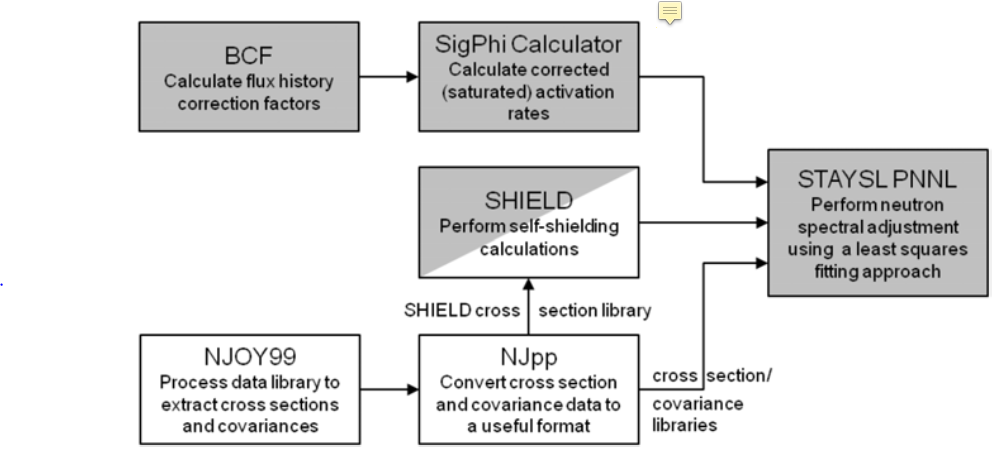
- This is from EPJWeb of Conferences 106, 07001 (2016) Least-Squares Neutron Spectral Adjustment with STAYSL PNNL L.R. Greenwooda and C.D. Johnson

# BCF - Beam Correction Factor
BCF corrects for irradiation history. The calculations performed correct for production and decay during the irradiation. At constant power or flux, this is a simple process 

$A_{0}=A_{\infty}*(1-exp(-\lambda*t))$

BCF normalizes the irradiation history to the time-weighted average reactor power or beam current. A correction factor is produced based on the irradiation hisotry for each isotope of interest. 

For the NIF, this module is not needed, BCF is not needef for a short irradiation time

## SHIELD
The SHIELD code calculates energy-dependent neutron self-shielding cross section correction factors that are used, prior to neutron spectral adjustment, to shield the neutron activation cross sections used by the STAYSL PNNL code. 

SHIELD was performed on ["shldinputNIF.dat"](https://github.com/nickquartemont/NENG612/tree/master/NIF_Unfold/Unfold/SHIELD/shldinputNIF.dat). 

After a painstaking process of trial and error. It was determined that my executable of the SHIELD.exe can only be ran if: 
- Run command prompt as an administrator
- Use runExample batch file with filename replaced with desired input

I am unsure of why it requires this, I am guessing it is a permissions issue that I cannot work out. 

SHIELD is only necessary/valid on non-threshold reactions (n,gamma). SHIELD is dependent on the thickness of the material, so it must be re-ran if different foils/wires are used. 

An output file is created in the same directory shldinput.out

All foils are 1 mm (39.3701 mils) except for the Au foils, which are 0.1 mm

The output is renamed sshldlib.dat


## SigPhi Calculator

The [SigPhi Calculator](https://github.com/nickquartemont/NENG612/tree/master/NIF_Unfold/Unfold/SIGPHI/SigPhi_Calculator_NIF.xlsm) was filled in with data from the [foil and activity information] (https://github.com/nickquartemont/NENG612/tree/master/NIF_Unfold/ActivationData.xlsx)


The purpose of the SigPhi Calculator software is to calculate corrected saturated neutron activation rates from measured activities. These reaction rates, the so-called sig-phi values, represent the product of the spectral-averaged neutron activation cross section and the total neutron flux

The NIF is a very prompt output (~200 ps). There will be some downscatter which may slow a portion down. However, for the purposes of the irradiation, the irradiation time is taken as 1 second, and the reaction rates are taken as per second. This will not impact the results because the half-lives of the measured products are orders of magnitude different from this result. 

The export to excel did not work. Instead, the input was built-up using the calculated gamma shielding and At/At-s from the foil and activity information sheet

I couldn't get the SigPhi Calculator to work for me. I redownloaded everything and it gives me: 
￿￿￿￿￿￿￿￿￿￿ when I try to export to a STAYSL script. After this is completed. I plan on sending in the bugs to PNNL

The sig-phi is calculated by dividing the number of nuclei created at t0 by the total number of atoms present in the foil. This is the relative production. 

The self-shielding factor for gammas is divided by this to correct for gamma self-shielding


# STAYSL

The STAYSL input deck was made with the SIG_PHI calculator and foil/activation data. 

The default values (From examples distributed with STAYSL) for Gaussian formalism were used. 

An iterative solution was performed on the input data and sets the uncertainty below 13 MeV to 100%. This was chosen because the model did not predict the down-scattering well. The baseline guess spectrum was initially developed using an Appelbe source split with a 14.03 MeV neutron peak at 10.75 keV temperature (See foil/activation Excel doc). 

After the initial results from the Appelbe source, it was clear that there was a large downscattering term. 

An estimation of the foil (13-14 MeV and 14-15 MeV) flux was done in the activation spreadsheet. The (n,2n) reactions were almost exactly what the guess predicted; however, the (n,g) and (n,n') reactions were underpredicting by over an order of magnitude. 

The guess spectrum was changed to a previous NIF shot. 

In [19]:
import sys
import os
sys.path.insert(0,os.path.abspath('C:/Users/nickq/Documents/AFIT_Masters/PyScripts/src'))


STAYSL is ran by executing the executable from the command line. The first iteration of STAYSL is performed manually. The output from that is placed into folder Iteration1. 

# Pinhole Results

In [7]:
import pandas as pd
from DataAnalysis.DataManipulation import bin_integration, bin_differentiation

path = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/stayslin.out'
df = pd.read_table(path, engine='python', sep='\s+', skiprows=101, skipfooter=649, header=None,
                   names=['lowE', 'adjFlux', 'unadjFlux', 'fluxRatio', 'adjStd', 
                          'unadjStd', 'uncertRatio', 'integralFlux', 'intFluxUncert'])

df.apply(pd.to_numeric)

df['adjFlux'] = bin_integration(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low')
df['adjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low', True)
df['unadjFlux'] = bin_integration(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low')
df['unadjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low', True)

df['adjLethargyStd'] = df['adjStd'] * df['adjLethargy'] / 100
df['unadjLethargyStd'] = df['unadjStd'] * df['adjLethargy'] / 100
df['adjStd'] = df['adjStd'] * df['adjFlux'] / 100
df['unadjStd'] = df['unadjStd'] * df['unadjFlux'] / 100

df['adjStd']

18    2.217235e+06
19    5.681330e+06
20    4.371891e+06
21    6.579449e+06
22    1.429957e+07
23    2.121990e+07
24    2.000462e+07
25    1.732670e+07
26    1.846450e+07
27    1.768999e+07
28    1.748101e+07
29    1.412276e+07
30    1.711191e+07
31    2.383092e+07
32    2.529170e+07
33    4.775300e+07
34    7.455020e+07
35    1.421363e+08
36    3.292947e+08
37    3.759505e+08
38    6.980784e+08
39    6.747157e+08
40    1.136803e+09
41    1.255624e+09
42    1.729809e+09
43    1.758754e+09
44    2.183804e+09
45    3.157827e+09
46    2.847437e+09
47    3.278249e+09
          ...     
66    9.801799e+09
67    9.283982e+09
68    8.833668e+09
69    1.133600e+10
70    9.642990e+09
71    2.343834e+10
72    2.189175e+10
73    2.310484e+10
74    2.374799e+10
75    2.041897e+10
76    2.764980e+10
77    4.069410e+10
78    1.946683e+10
79    2.346320e+10
80    2.454849e+10
81    2.142754e+10
82    1.622298e+10
83    1.592888e+10
84    1.252668e+10
85    1.020026e+10
86    1.462011e+10
87    1.5120

Plot first result

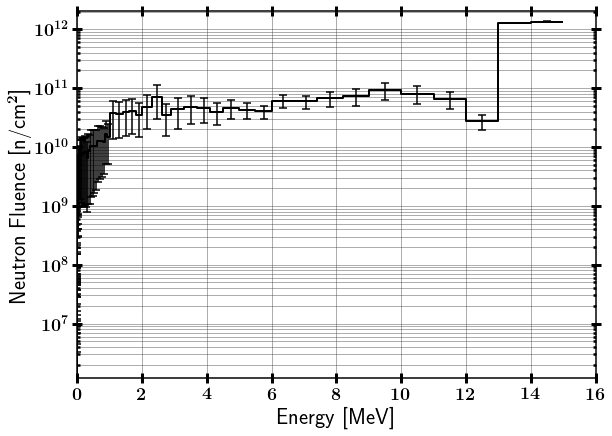

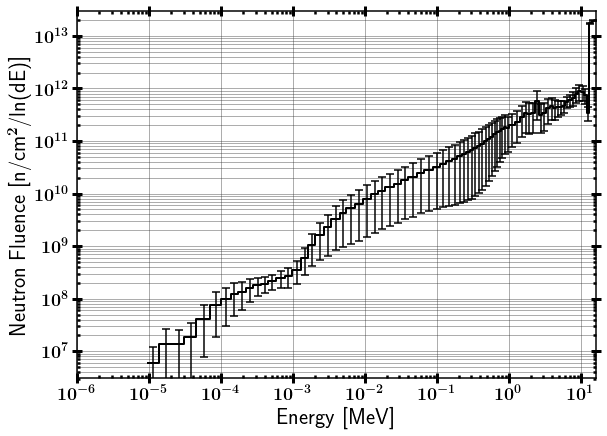

In [5]:
from DataAnalysis.Histograms import Histogram
import matplotlib
%matplotlib inline

outpath ='C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/'
adjHisto = Histogram()
adjHisto.build_histo(df['lowE'].tolist(), df['adjFlux'].tolist(), uncert=df['adjStd'].tolist(),
                     edgeLoc='low')

adjHisto.plot(xMin=1E-6, logX=False, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',
                  savePath=outpath+'Pin1',includeMarkers=False,
                  legend=False)
adjLethargyHisto = Histogram()
adjLethargyHisto.build_histo(df['lowE'].tolist(), df['adjLethargy'].tolist(), uncert=df['adjLethargyStd'].tolist(),
                     edgeLoc='low')

adjLethargyHisto.plot( xMin=1E-6, logX=True, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$/ln(dE)]',
                  savePath=outpath+'Pin1d_Lethargic',includeMarkers=False,
                  legend=False)

# Pin Iterative Solution:
  - The iterative solution sets the uncertainty below 13 MeV to 100%.
  - It does not update the uncertainty until $\chi^2$ converged.

In [15]:
from Unfolding.STAYSL import IterativeSTAYSL

stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration1/'

# Build Data Structure Lists
iterSoln = []
iterAdjHisto = []
iterRatioHisto = []

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=False, chiConv=0.1))
print iterSoln[-1]

iterSoln[-1].run()

# Convert to lethargy
iterSoln[-1]._df['adjLethargy'] =  bin_differentiation(iterSoln[-1]._df['lowE'].tolist(),
                                                     iterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
iterAdjHisto.append(Histogram())
iterRatioHisto.append(Histogram())

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration1/
$\chi^2$ Convergence: 0.1
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: False
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration1/stayslin.out
Chi^2 = 34.06233, Std Norm = 6.20822220527
Chi^2 = 20.66275
Chi^2 = 15.64945
Chi^2 = 13.50027
Chi^2 = 12.03089
Chi^2 = 10.80222
Chi^2 = 9.82855
Chi^2 = 9.00026
Chi^2 = 8.3121
Chi^2 = 7.72605
Chi^2 = 7.2275
Chi^2 = 6.79891
Chi^2 = 6.42842
Chi^2 = 6.10673
Chi^2 = 5.82561
Chi^2 = 5.57934
Chi^2 = 5.36202
Chi^2 = 5.17007
Chi^2 = 4.9996
Chi^2 = 4.84776
Chi^2 = 4.712
Chi^2 = 4.59037
Chi^2 = 4.48087
Chi^2 = 4.38187
Std Norm = 7.43564433926, 7.12396212862
Std Norm = 7.434369557, 7.43564433926


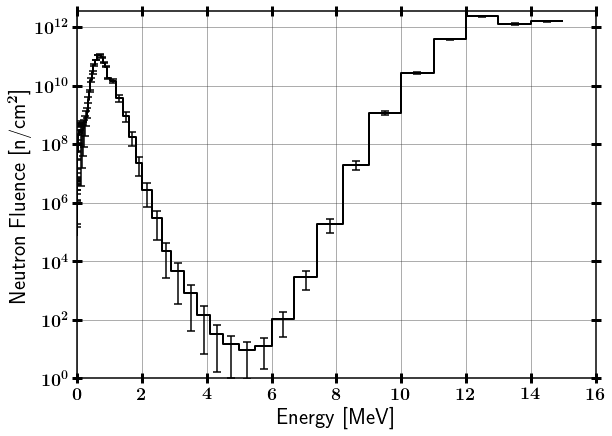

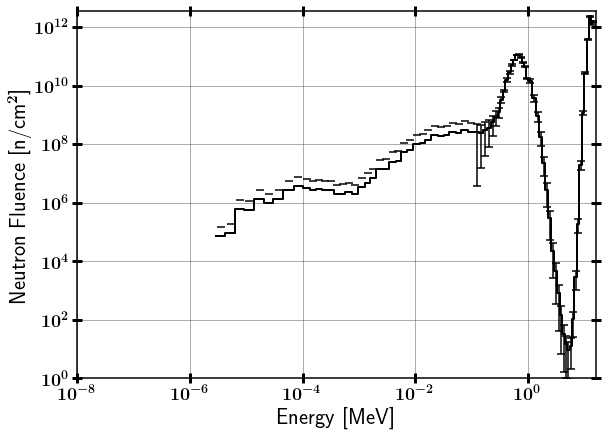

In [20]:
iter = 0
iterAdjHisto[iter].build_histo(iterSoln[iter]._df['lowE'].tolist(),iterSoln[iter]._df['adjFlux'].tolist(),
                             uncert=(iterSoln[iter]._df['adjStd']*iterSoln[iter]._df['adjFlux']).tolist(),
                             edgeLoc='low', name='STAYSL')

iterAdjHisto[iter].plot(xMin=1E-8, xMax=16, yMin=1, logX=False, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',legend=False,
                        savePath=outpath+'PIN-Unfold_Itr{:1d}'.format(iter))
iterAdjHisto[iter].plot(xMin=1E-8, xMax=16, yMin=1, logX=True, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',legend=False,
                        savePath=outpath+'PINlog-Unfold_Itr{:1d}'.format(iter))



Find the p value 

In [17]:
import scipy.stats as stats
#http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-25-chi.html
crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 4)   # Df = number of variable categories - 1

print("Critical value")
print(crit)

p_value = 1 - stats.chi2.cdf(x=4.38*4,  # Find the p-value
                             df=4)
print("P value")
print(p_value)

Critical value
9.48772903678
P value
0.0015311937798


# Basket


In [ ]:
from Unfolding.STAYSL import IterativeSTAYSL

stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration2/'

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=True, chiConv=0.1))
print iterSoln[-1]

iterSoln[-1].run()

# Convert to lethargy
iterSoln[-1]._df['adjLethargy'] =  bin_differentiation(iterSoln[-1]._df['lowE'].tolist(),
                                                     iterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
iterAdjHisto.append(Histogram())
iterRatioHisto.append(Histogram())
iter = 1

iterAdjHisto[iter].build_histo(iterSoln[iter]._df['lowE'].tolist(),iterSoln[iter]._df['adjFlux'].tolist(),
                             uncert=(iterSoln[iter]._df['adjStd']*iterSoln[iter]._df['adjFlux']).tolist(),
                             edgeLoc='low', name='STAYSL')

iterAdjHisto[iter].plot(xMin=1E-6, xMax=16, yMin=1, logX=False, logY=True, includeMarkers=False,
              xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',
                        savePath=outpath+'PIN-Unfold_Itr{:1d}'.format(iter))

# Iterative Method 3:

  - No modifications are made to the MCNP results for the guess spectrum
  - It does update the uncertainty throughout the convergence process. 

In [ ]:
from Unfolding.STAYSL import IterativeSTAYSL

stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration3/'
iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=True, chiConv=1))
print iterSoln[-1]

iterSoln[-1].run()

# Convert to lethargy
iterSoln[-1]._df['adjLethargy'] =  bin_differentiation(iterSoln[-1]._df['lowE'].tolist(),
                                                     iterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
iterAdjHisto.append(Histogram())
iterRatioHisto.append(Histogram())
iter = 2

iterAdjHisto[iter].build_histo(iterSoln[iter]._df['lowE'].tolist(),iterSoln[iter]._df['adjFlux'].tolist(),
                             uncert=(iterSoln[iter]._df['adjStd']*iterSoln[iter]._df['adjFlux']).tolist(),
                             edgeLoc='low', name='STAYSL')

iterAdjHisto[iter].plot(xMin=1E-6, xMax=16, yMin=1, logX=False, logY=True, includeMarkers=False,
              xLabel='Energy [MeV]', yLabel='Neutron Flux [n/cm$^2$]',
                        savePath=outpath+'PIN-Unfold_Itr{:1d}'.format(iter))